In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas_indexing
import pyam

In [2]:
def read_vars(fname, vars=[]):
    df = pd.read_csv(fname)
    df = df[df.Variable.isin(vars)]
    return df

In [145]:
fnames = [
    '../raw_data/AR6_Scenarios_Database_World_v1.1.csv',
    '../raw_data/AR6_Scenarios_Database_R5_regions_v1.1.csv',
    '../raw_data/AR6_Scenarios_Database_R10_regions_v1.1.csv',
    ]

data = [read_vars(fname, vars=['Carbon Sequestration|CCS', 'Carbon Sequestration|CCS|Fossil']) for fname in fnames]

In [146]:
levels = ['Model', 'Scenario']
gidx = data[0].set_index(levels).pix.unique(levels=levels)
r5idx = data[1].set_index(levels).pix.unique(levels=levels)
r10idx = data[2].set_index(levels).pix.unique(levels=levels)

In [147]:
gidx.difference(r5idx).unique('Model')

Index(['AIM/Hub-Global 2.0', 'En-ROADS-96', 'GCAM 4.2',
       'IEA Energy Technology Perspectives Model 2020', 'McKinsey 1.0',
       'POLES CD-LINKS', 'POLES EMF30', 'TIAM-ECN ETH 1.1', 'TIAM-ECN KEN 1.1',
       'TIAM-ECN MDG 1.1', 'WEM 2021'],
      dtype='object', name='Model')

Has R5
True     2985
False     187
Name: count, dtype: int64

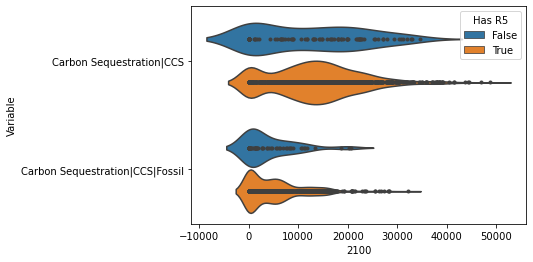

In [148]:
check = data[0].copy()
check['Has R5'] = True
check.loc[check['Model'].isin(gidx.difference(r5idx).unique('Model')), 'Has R5'] = False
sns.violinplot(data=check, y='Variable', x='2100', hue='Has R5', inner="point")
check['Has R5'].value_counts()

In [149]:
r5idx.difference(r10idx).unique('Model')

Index(['AIM/CGE 2.0', 'AIM/CGE 2.1', 'AIM/Hub-Global 2.0', 'BET EMF33',
       'CONTO-RUS 1.0', 'COPPE-COFFEE 1.0', 'DNE21+ V.14C', 'DNE21+ V.14E1',
       'DNE21+ V.14E2', 'FARM 3.2', 'GCAM 4.2', 'GRAPE-15 1.0',
       'IMACLIM-NLU 1.0', 'IMAGE 3.0.1', 'IMAGE 3.0.2', 'MERGE-ETL 6.0',
       'MESSAGE V.3', 'MESSAGE-GLOBIOM 1.0', 'MESSAGEix-GLOBIOM 1.0',
       'MESSAGEix-GLOBIOM_1.0', 'POLES ADVANCE', 'POLES EMF33', 'POLES ENGAGE',
       'POLES GECO2019', 'REMIND 1.6', 'REMIND 1.7', 'REMIND-MAgPIE 1.5',
       'REMIND-MAgPIE 1.7-3.0', 'TIAM-Grantham 1.0', 'WITCH-GLOBIOM 3.1',
       'WITCH-GLOBIOM 4.2', 'WITCH-GLOBIOM 4.4'],
      dtype='object', name='Model')

Has R10
True     1877
False    1230
Name: count, dtype: int64

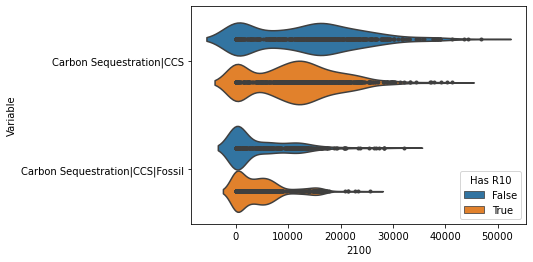

In [150]:
check = data[1].copy().set_index(['Model', 'Scenario', 'Region', 'Variable', 'Unit']).pix.aggregate(Region={'World': data[1]['Region'].unique()}, mode='return').reset_index()
check['Has R10'] = True
check.loc[check['Model'].isin(r5idx.difference(r10idx).unique('Model')), 'Has R10'] = False
sns.violinplot(data=check, y='Variable', x='2100', hue='Has R10', inner="point")
check['Has R10'].value_counts()

# Now we interpolate, add cumulative variables, and set values at net-zero

In [151]:
df = pyam.IamDataFrame(pd.concat(data)).interpolate(range(2010, 2101))

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\utils.py:318: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=True)


<Axes: title={'center': 'scenario: EMF33_Med2C_cost100 - region: World'}, xlabel='Year', ylabel='Mt CO2/yr'>

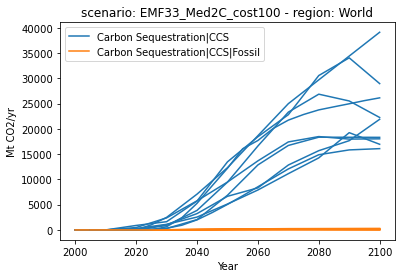

In [159]:
df.filter(region='World', scenario='EMF33_Med2C_cost100').plot.line(color='variable')

In [152]:
def make_cumulative_df(df, vold, vnew, offset=False):
    y1 = offset or 2010
    y2 = 2100
    data = df.filter(variable=vold).interpolate(range(y1, y2 + 1))
    if offset:
        data = data.offset(year=y1) # NB this fails if there is no value in the year
    pddata = (
        data
        .filter(year=range(y1, y2 + 1))
        .rename(variable={vold: vnew})
        .timeseries()
    )
    ret = pyam.IamDataFrame(pddata.cumsum(axis=1))
    ret.set_meta(data.meta)
    return ret

In [153]:
cdf = pyam.concat([
    make_cumulative_df(df, vold='Carbon Sequestration|CCS', vnew='Cumulative Carbon Sequestration|CCS'),
    make_cumulative_df(df, vold='Carbon Sequestration|CCS|Fossil', vnew='Cumulative Carbon Sequestration|CCS|Fossil'),
])

In [154]:
data = pyam.concat([df, cdf])
data.to_csv('../processed_data/102_ccs_data_r5_r10.csv')


In [155]:
data.load_meta('../raw_data/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx')


[WARNING] 16:29:02 - pyam.core: No meta indicators for the following scenarios:
           model             scenario
0  CONTO-RUS 1.0       RUS_Aggressive
1  CONTO-RUS 1.0         RUS_Baseline
2  CONTO-RUS 1.0            RUS_Smart
3   GCAM-USA 5.3  EN_NP_2025_-1002050
4   GCAM-USA 5.3   EN_NP_2025_-502050
...
[WARNING] 16:29:02 - pyam.core: Ignoring meta indicators for the following scenarios:
         model           scenario
0  AIM/CGE 2.0   ADVANCE_NoPolicy
1  AIM/CGE 2.0  ADVANCE_Reference
2  AIM/CGE 2.0    EMF30_BCOC-EndU
3  AIM/CGE 2.0     EMF30_Baseline
4  AIM/CGE 2.0     EMF30_CH4-Only
...


In [156]:
def value_at_net_zero(row, nz):
    year = nz.loc[row.name[0], row.name[1]]
    return row[year] if np.isfinite(year) else np.nan

nz = data.meta['Year of netzero CO2 emissions (Harm-Infilled) Table SPM2']
nz_co2 = data.timeseries().apply(value_at_net_zero, args=(nz,), axis=1).pix.assign(year=-1) # NB: net-zero co2 year is set to -1

nz = data.meta['Year of netzero GHG emissions (Harm-Infilled) Table SPM2']
nz_ghg = data.timeseries().apply(value_at_net_zero, args=(nz,), axis=1).pix.assign(year=-2) # NB: net-zero ghg year is set to -2

pyam.IamDataFrame(pd.concat([nz_co2, nz_ghg])).to_csv('../processed_data/102_netzero_ccs_data_r5_r10.csv')


## Quick Check

[INFO] 16:29:12 - pyam.core: Reading file ..\processed_data\102_netzero_ccs_data_r5_r10.csv
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\utils.py:318: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=True)
[WARNING] 16:29:14 - pyam.core: Ignoring meta indicators for the following scenarios:
         model            scenario
0  AIM/CGE 2.0  ADVANCE_2020_Med2C
1  AIM/CGE 2.0  ADVANCE_2030_Med2C
2  AIM/CGE 2.0        ADVANCE_INDC
3  AIM/CGE 2.0    ADVANCE_NoPolicy
4  AIM/CGE 2.0   ADVANCE_Reference
...


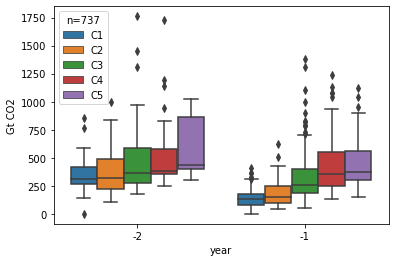

In [157]:
data = pyam.IamDataFrame('../processed_data/102_netzero_ccs_data_r5_r10.csv')
data.load_meta('../raw_data/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx')

ax = (
    data
    .filter(variable='Cumulative Carbon Sequestration|CCS', year=[-1, -2], region='World')
    .filter(Category='C*')
    .convert_unit('Mt CO2/yr', 'Gt CO2', factor=1e-3)
    .plot.box(x="year", by="Category", legend=True)
)